# Multistart minimizer
Here, I implement multistart minimization algorithm. This is a global multivariate function minimizer.
The idea of this algorithm is the following: Take any local optimization method. Randomly generate `N` different initial guesses. Start the local optimizer from all those `N` initial guesses. Collect the `N` optimization results. Select and return the best optimization result.

To my knowledge, this algorithm is implemented in MatLab (`multisearch`) and in the Excel Add-on Solver.

It was shown that for certain optimization problems this algorithm performs better than other global optimization algorithms (Raue et al., 2013).

## Implementation

For my implementation I choose to draw the initital guesses from a uniform distribution. The user has to specify the lower and upper boundaries of those uniform distributions. 
I now chose that all lower and upper boundaries should be given in the iterables `x0min` and `x0max`, respectively. Maybe it would be preferable to instead require one iteratable of tuples and each tuple specifies min and max. This would be closer to the syntax of `sp.optimize.brute`.
I use `sp.optimize.minimize` to perform the local optimization, so in principle any of the local optimization algorithms supported by `sp.optimize.minimize` can be used for `multistart`.

In [1]:
import scipy as sp
import numpy as np
from scipy import optimize

def multistart(fun, x0min, x0max, N, full_output = False, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None):
    res_list = sp.empty(N, dtype = object)
    for i in range(N):
        x0 = sp.random.uniform(x0min, x0max)
        res = sp.optimize.minimize(fun, x0, args, method, jac, hess, hessp, bounds, constraints, tol, callback, options)
        res_list[i] = res
    sort_res_list = res_list[sp.argsort([res.fun for res in res_list])]
    if full_output:
        return sort_res_list[0], sort_res_list
    else:
        return sort_res_list[0]

## Example 1

Lets look at a function with many local minima.

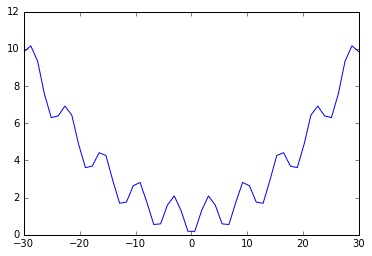

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def fun(x):
    return - sp.cos(x) + 0.01 * x ** 2 + 1

x = sp.linspace(-30, 30)
plt.plot(x, fun(x));

The local global minimum is located at $x = 0$. However, local optimizers will not find the global mimimum if they start from the wrong initial guess:

In [3]:
res = sp.optimize.minimize(fun, 20)
print res.x

[ 18.47117708]


The `multistart` algorithm is able to find the global minimum.

In [4]:
sp.random.seed(0)
res_multi = multistart(fun, -30, 30, 200)
print res_multi.x

[ -1.02995469e-08]


Raue et al., 2013 suggest a graphical inspection of all minimization results. They suggest to plot the function values sorted by the function value. This plot should follow a step like function. Each step corresponds to a local minimum. To enable this, I implemented a `full_output` option for which `multistart` not only returns the best optimization result but also a sorted list of all optimization results. This can be used for generating the suggested plot.

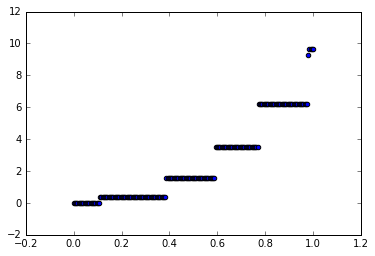

In [5]:
sp.random.seed(0)
res_multi, res_list = multistart(fun, -30, 30, 200, full_output=True)
plt.scatter(sp.linspace(0, 1, len(res_list)), [res.fun for res in res_list]);

## Example with 2 Parameters

A case with 2 parametersalso works:

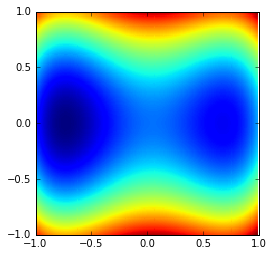

In [6]:
def fun2(x):
    return x[0]**4 - (x[0])**2 + 0.1*x[0] + x[1]**2

X, Y =sp.mgrid[-1:1:0.01, -1:1:0.01]

fig, ax = plt.subplots()
ax.pcolormesh(X, Y, fun2([X, Y]))
ax.set_aspect('equal')

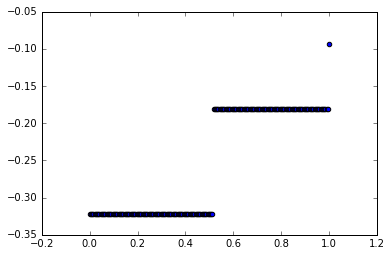

In [7]:
sp.random.seed(0)
res, res_list_2 = multistart(fun2, [-10, -5], [10, 5], 200, full_output=True)

plt.scatter(sp.linspace(0, 1, len(res_list_2)), [res.fun for res in res_list_2]);

## Comparisson with basinhopping

Without tuning of standard parameters basinhopping easily goes wrong:

In [47]:
res = sp.optimize.basinhopping(fun, 5)
res

                        fun: 0.3870336677706191
 lowest_optimization_result:       fun: 0.3870336677706191
 hess_inv: array([[ 0.98802936]])
      jac: array([  7.45058060e-09])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([ 6.15967798])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 1131
                        nit: 100
                       njev: 377
                          x: array([ 6.15967798])

While the global minimum is at 0, basinhopping returned 6.15967798.

`sp.optimize.basinhopping` only returns the global optimum. However, local minima can be saved via a callback function. This could also be an approach for `multistart`.

## Bibliography
Raue, A., Schilling, M., Bachmann, J., Matteson, A., Schelke, M., Kaschek, D., … Timmer, J. (2013). Lessons Learned from Quantitative Dynamical Modeling in Systems Biology. PLOS ONE, 8(9), e74335. http://doi.org/10.1371/journal.pone.0074335